## **Task 1: Feature Engineering**



##### **Load & Prepare the Dataset**

In [ ]:
import numpy as np
import pandas as pd
from joblib import dump

In [ ]:
from google.colab import files
files.upload()

Saving RUL_FD001.txt to RUL_FD001.txt
Saving test_FD001.txt to test_FD001.txt
Saving train_FD001.txt to train_FD001.txt


{'RUL_FD001.txt': b'112 \n98 \n69 \n82 \n91 \n93 \n91 \n95 \n111 \n96 \n97 \n124 \n95 \n107 \n83 \n84 \n50 \n28 \n87 \n16 \n57 \n111 \n113 \n20 \n145 \n119 \n66 \n97 \n90 \n115 \n8 \n48 \n106 \n7 \n11 \n19 \n21 \n50 \n142 \n28 \n18 \n10 \n59 \n109 \n114 \n47 \n135 \n92 \n21 \n79 \n114 \n29 \n26 \n97 \n137 \n15 \n103 \n37 \n114 \n100 \n21 \n54 \n72 \n28 \n128 \n14 \n77 \n8 \n121 \n94 \n118 \n50 \n131 \n126 \n113 \n10 \n34 \n107 \n63 \n90 \n8 \n9 \n137 \n58 \n118 \n89 \n116 \n115 \n136 \n28 \n38 \n20 \n85 \n55 \n128 \n137 \n82 \n59 \n117 \n20 \n',
 'test_FD001.txt': b'1 1 0.0023 0.0003 100.0 518.67 643.02 1585.29 1398.21 14.62 21.61 553.90 2388.04 9050.17 1.30 47.20 521.72 2388.03 8125.55 8.4052 0.03 392 2388 100.00 38.86 23.3735  \n1 2 -0.0027 -0.0003 100.0 518.67 641.71 1588.45 1395.42 14.62 21.61 554.85 2388.01 9054.42 1.30 47.50 522.16 2388.06 8139.62 8.3803 0.03 393 2388 100.00 39.02 23.3916  \n1 3 0.0003 0.0001 100.0 518.67 642.46 1586.94 1401.34 14.62 21.61 554.11 2388.05 9056.96 

In [ ]:
import os
os.listdir('/content')

['.config',
 'test_FD001.txt',
 'RUL_FD001.txt',
 'train_FD001.txt',
 'sample_data']

In [ ]:
# Load training data
df = pd.read_csv(
    "train_FD001.txt",
    sep=r"\s+",
    header=None
) # Read the file and split columns wherever there are one or more spaces or tabs, and assume there is no header row.

In [ ]:
# Column names based on NASA documentation
cols = (
    ["engine_id", "cycle"] +
    [f"op_setting_{i}" for i in range(1, 4)] +
    [f"sensor_{i}" for i in range(1, 22)]
)

In [ ]:
df.columns = cols

In [ ]:
df.head()

engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1       -0.0007       -0.0004         100.0    518.67   
1          1      2        0.0019       -0.0003         100.0    518.67   
2          1      3       -0.0043        0.0003         100.0    518.67   
3          1      4        0.0007        0.0000         100.0    518.67   
4          1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392       2388      100.0   
1    8131.49     8.4318       0.03        392       2388      100.0   
2    8133.23     8.4178       0.03        390       2388      100.0   
3    8133.83     8.3682       0.03        392       2388      100.0   
4    8133.80     8.4294       0.03        393       2388      100.0   

   sensor_20  sensor_21  
0      39.06    23.4190  
1      39.00    23.4236  
2      38.95    23.3442  
3      38.88    23.3739  
4      38.90    23.4044  

[5 rows x 26 columns]

##### **Create Remaining Useful Life (RUL)**

In [ ]:
# Max cycle per engine
max_cycle = df.groupby("engine_id")["cycle"].max()

In [ ]:
# Map max cycle
df["max_cycle"] = df["engine_id"].map(max_cycle)

In [ ]:
# Remaining Useful Life
df["RUL"] = df["max_cycle"] - df["cycle"]

##### **Create 24-Hour Failure Label (Classification Target)**

In [ ]:
FAILURE_WINDOW = 24  # 24 hours / cycles

In [ ]:
df["failure_next_24hrs"] = (df["RUL"] <= FAILURE_WINDOW).astype(int) # If Remaining Useful Life (RUL) ≤ 24 cycles, failure will happen within the next 24 hours

In [ ]:
df[['RUL','failure_next_24hrs']]

RUL  failure_next_24hrs
0      191                   0
1      190                   0
2      189                   0
3      188                   0
4      187                   0
...    ...                 ...
20626    4                   1
20627    3                   1
20628    2                   1
20629    1                   1
20630    0                   1

[20631 rows x 2 columns]

#### **Feature Engineering**

##### **A. Rolling Mean & Standard Deviation(Last 1, 6, 12 hours)**

In [ ]:
WINDOWS = [6, 12] # rolling time windows
SENSORS = [f"sensor_{i}" for i in range(1, 22)] # list of sensor columns

Why 1 is NOT included in WINDOWS = [6, 12]?
* The rolling mean of 1 value = the value itself
* So this feature is identical to the original sensor
* It adds no new pattern or trend
* Standard deviation needs at least 2 values
* With 1 value → result is NaN

In [ ]:
feature_dict = {} # Collect features in a dictionary which helps to generate features WITHOUT inserting into df

In [ ]:
for sensor in SENSORS:
    for w in WINDOWS:
        feature_dict[f"{sensor}_roll_mean_{w}"] = (
            df.groupby("engine_id")[sensor] # Each engine has its own independent life cycle. Rolling stats are calculated only within the same engine
              .rolling(window=w) # Look at the previous w time steps, including the current one.
              .mean() # it captures: Overall trend & Smooths noisy sensor data
              .reset_index(level=0, drop=True)# groupby().rolling() creates a MultiIndex. Pandas can’t assign it directly to the DataFrame .Removes the engine_id index level & Aligns values correctly with original rows
        )

        feature_dict[f"{sensor}_roll_std_{w}"] = (
            df.groupby("engine_id")[sensor]
              .rolling(window=w)
              .std() # it captures: Variability / instability & Sudden fluctuations often indicate degradation
              .reset_index(level=0, drop=True)
        )
# For every sensor and every time window, it creates rolling statistical features (mean and standard deviation) separately for each engine.
# This helps the ML model understand trends and variability in sensor behavior over time.

In [ ]:
rolling_features = pd.DataFrame(feature_dict)

In [ ]:
df = pd.concat([df, rolling_features], axis=1)

### **B. Exponential Moving Average (EMA)**

EMA gives more weight to recent sensor values.

In [ ]:
ema_features = {} # It helps to stores the generated EMA feature in a dictionary instead of directly adding it to df

In [ ]:
for sensor in SENSORS: # Loops through all sensor columns
    ema_features[f"{sensor}_ema_6"] = (
        df.groupby("engine_id")[sensor] # Groups data by engine. Ensures EMA is calculated per engine lifecycle
          .ewm(span=6, adjust=False) # Applies Exponential Weighted Moving Average. span=6 → recent 6 time steps get higher weight. adjust=False → uses recursive EMA formula (standard in ML & signal processing)
          .mean() # Computes the EMA values. Despite the name, EMA is not a simple average—it weights recent values more heavily.
          .reset_index(level=0, drop=True) # Removes the engine_id index created by groupby()
    )

    ema_features[f"{sensor}_ema_12"] = (
        df.groupby("engine_id")[sensor]
          .ewm(span=12, adjust=False)
          .mean()
          .reset_index(level=0, drop=True)
    )

This code creates Exponential Moving Average (EMA) features for each sensor, calculated separately for each engine, using two time windows:

* EMA(6) → short-term behavior

* EMA(12) → medium-term behavior

These features help the model detect early degradation patterns in sensor readings.

In [ ]:
ema_df = pd.DataFrame(ema_features)

In [ ]:
df = pd.concat([df, ema_df], axis=1)

### **C. Lag Features (t-1, t-2)**

Lag features capture temporal dependency.

This creates lag (historical) features for each sensor so the ML model can learn:

How past sensor values influence future failures

Lag features are essential in time-series prediction and prevent data leakage.

In [ ]:
LAGS = [1, 2] #Lag-1 → previous time step
# Lag-2 → two time steps ago

In [ ]:
lag_features = {}

In [ ]:
for sensor in SENSORS:
    for lag in LAGS:
        lag_features[f"{sensor}_lag_{lag}"] = (
            df.groupby("engine_id")[sensor]
              .shift(lag) # Shifts sensor values backward in time & Creates historical context
        )

In [ ]:
lag_df = pd.DataFrame(lag_features)

In [ ]:
df = pd.concat([df, lag_df], axis=1)

In [ ]:
df.columns

Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
       ...
       'sensor_17_lag_1', 'sensor_17_lag_2', 'sensor_18_lag_1',
       'sensor_18_lag_2', 'sensor_19_lag_1', 'sensor_19_lag_2',
       'sensor_20_lag_1', 'sensor_20_lag_2', 'sensor_21_lag_1',
       'sensor_21_lag_2'],
      dtype='object', length=197)

### **Handle Missing Values**


Rolling and lag features create NaN values at the beginning of each time series.

The maximum window or lag tells us how many initial rows must be dropped to remove all NaNs safely.

In [ ]:
MAX_WINDOW = max(max(WINDOWS), max(LAGS)) #finds the largest value among all rolling window sizes (WINDOWS) and lag steps (LAGS)

In [ ]:
MAX_WINDOW

12

In [ ]:
df = df[df.groupby("engine_id").cumcount() >= MAX_WINDOW].reset_index(drop=True)
#removes the first few rows of each engine where time-series features (rolling, lag, EMA) are not fully available.
#cumcount():It counts rows within each group, starting from 0, and increases by 1 for every new row in that group.

### **Select Final Feature Set**

In [ ]:
FEATURE_COLUMNS = [
    col for col in df.columns
    if "sensor_" in col and
    ("roll" in col or "ema" in col or "lag" in col)
]

In [ ]:
X = df[FEATURE_COLUMNS]
y = df["failure_next_24hrs"]

In [ ]:
X.isna().sum().sum()

np.int64(0)

### **Efficient Serialization Using joblib**


In [ ]:
dump(X, "X_features_FD001.joblib")# dump() serializes (converts) Python objects into binary files. Files are saved on disk with .joblib extension
dump(y, "y_labels_FD001.joblib")

['y_labels_FD001.joblib']

In [ ]:
from joblib import load

In [ ]:
X = load("X_features_FD001.joblib") # Reads binary .joblib files. Reconstructs the original Python objects in memory
y = load("y_labels_FD001.joblib")

## **Task 2: Modeling**


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#stratify=y: Ensures failures appear in both train & test. Mandatory for <1% imbalance

### **Baseline Model: Logistic Regression**


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()), #Scales all features to the same range so Logistic Regression works properly

    ("smote", SMOTE(
        sampling_strategy="auto", #Generates synthetic samples for the minority class to balance the dataset.(applied only on training data, no data leakage).
        random_state=42
    )),

    ("model", LogisticRegression(
        max_iter=1000, #ensures convergence
        class_weight=None, #not needed because SMOTE balances classes
        n_jobs=-1 #uses all CPU cores for faster training
    ))
])

In [ ]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(max_iter=1000, n_jobs=-1))])

In [ ]:
#Evaluate Logistic Regression (PR-AUC)
from sklearn.metrics import average_precision_score, precision_recall_curve

y_probs_lr = logreg_pipeline.predict_proba(X_test)[:, 1]
pr_auc_lr = average_precision_score(y_test, y_probs_lr)
#calculates the probability of positive class predictions and evaluates the model using precision-recall performance.

print("Logistic Regression PR-AUC:", pr_auc_lr)

Logistic Regression PR-AUC: 0.9742292040670566


**Precision–Recall tradeoff (High Precision focus)**

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_lr)

pr_df = pd.DataFrame({
    "precision": precision[:-1],
    "recall": recall[:-1],
    "threshold": thresholds
})

pr_df.sort_values("precision", ascending=False).head()

precision  recall  threshold
3879        1.0   0.016        1.0
3864        1.0   0.046        1.0
3886        1.0   0.002        1.0
3885        1.0   0.004        1.0
3884        1.0   0.006        1.0

### **Production Model: XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# Count class distribution
negative_samples = (y_train == 0).sum()
positive_samples = (y_train == 1).sum() #Counts how many non-failure (0) and failure (1) samples are in the training data.

scale_pos_weight = negative_samples / positive_samples #Computes how much more weight the model should give to the rare failure class

print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 6.772


In [ ]:
xgb_production_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()), #Scales numerical features so the model trains more stably

    ("model", XGBClassifier(
        objective="binary:logistic", #binary classification with probability output
        eval_metric="aucpr", #evaluates using Precision-Recall AUC (best for imbalance)
        scale_pos_weight=scale_pos_weight, #increases importance of rare failure class

        n_estimators=400, #number of boosting trees
        max_depth=6, #controls model complexity
        learning_rate=0.05, #slow, stable learning
        subsample=0.8,
        colsample_bytree=0.8, #reduce overfitting

        n_jobs=-1, #use all CPU cores
        random_state=42 #reproducible results
    ))
])

In [ ]:
xgb_production_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [ ]:
#Evaluate XGBoost
y_pred_proba = xgb_production_pipeline.predict_proba(X_test)[:, 1] #[:, 1] selects the probability of the positive (failure) class

pr_auc = average_precision_score(y_test, y_pred_proba)
print("PR-AUC:", pr_auc)

PR-AUC: 0.9940130134606711


Precision–Recall Curve

In [ ]:
import matplotlib.pyplot as plt

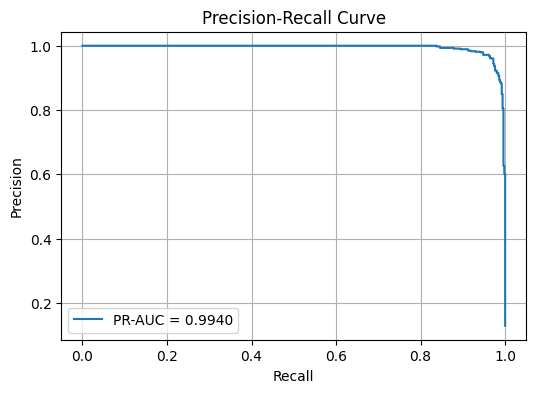

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR-AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

**Threshold Selection (High Precision Strategy)**

selects the classification threshold that achieves ≥95% precision while maximizing recall

In [ ]:
target_precision = 0.95

thresholds = thresholds[:len(precision)-1] #Aligns the number of thresholds with precision/recall values (PR curves return one extra precision point).

valid_idx = np.where(precision[:-1] >= target_precision)[0] #Finds indices where precision is at least 0.95.

best_idx = valid_idx[np.argmax(recall[valid_idx])] #Among those valid points, selects the one with the highest recall.

best_threshold = thresholds[best_idx] #Gets the decision threshold corresponding to that best point.

print("Selected threshold:", best_threshold)
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])

Selected threshold: 0.42196584
Precision: 0.9510763209393346
Recall: 0.972


In [ ]:
#converts predicted probabilities into final binary class predictions using the custom threshold instead of the default 0.5.
y_pred_custom = (y_pred_proba >= best_threshold).astype(int)

In [ ]:
#Final Evaluation Metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_custom, digits=4))

              precision    recall  f1-score   support

           0     0.9959    0.9926    0.9942      3387
           1     0.9511    0.9720    0.9614       500

    accuracy                         0.9900      3887
   macro avg     0.9735    0.9823    0.9778      3887
weighted avg     0.9901    0.9900    0.9900      3887



### **Hyperparameter Tuning via GridSearchCV**

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

In [ ]:
# Define Pipeline
xgb_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=42
    ))
])

In [ ]:
# Hyperparameter Grid
param_grid = {
    "xgb__n_estimators": [200, 400],
    "xgb__max_depth": [4, 6],
    "xgb__learning_rate": [0.03, 0.05],
    "xgb__subsample": [0.8, 1.0],
    "xgb__colsample_bytree": [0.8, 1.0]
}

In [ ]:
# PR-AUC Scorer:This scorer makes GridSearchCV evaluate models using PR-AUC
pr_auc_scorer = make_scorer(  #Creates a custom scoring function for model evaluation
    average_precision_score,
    needs_proba=True #tells GridSearchCV to use predicted probabilities, not class labels
)

In [ ]:
# GridSearchCV Setup
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #Splits data into 3 folds.Stratified → keeps class imbalance ratio the same in each fold. shuffle=True → randomizes samples

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid, #Tries all parameter combinations in param_grid
    scoring=pr_auc_scorer,
    cv=cv, #Uses stratified cross-validation
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='aucpr',
                                                      feature...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__learning_rate': [0.03, 0.05],
                         'xgb__max_depth': [4, 6],
                         'xgb__n_estimators': [200, 400],
                         'xgb__subsample': [0.8, 1.0]},
             scoring=make_scorer(average_precision_score, response_method='predict', needs_proba=True),
             verbose=2)

In [ ]:
#Best Parameters
print("Best Parameters:")
print(grid_search.best_params_)

Best Parameters:
{'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.03, 'xgb__max_depth': 4, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}


In [ ]:
#Final Model (GridSearch Best)
best_xgb_grid = grid_search.best_estimator_

In [ ]:
#Evaluate on Test Data
y_pred_proba = best_xgb_grid.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, y_pred_proba)
print("Test PR-AUC:", pr_auc)

Test PR-AUC: 0.9821584579236332
